#### This models what occurs in the tumor tissue, from a starting point of macrophages that have localized to the tumor — the ME part of ADME

# Imports and useful functions

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from collections import namedtuple

def make_plot_look_good(axes):
    axes.axhline(0, color=[0.2, 0.2, 0.2], linewidth=1)
    axes.axvline(0, color=[0.2, 0.2, 0.2], linewidth=1)
    axes.grid(True, which='both', linestyle='--', linewidth=0.5)
    for spine in axes.spines.values():
        spine.set_visible(False)

def set_axes_labels(axes, x_label, y_label, title, legend_title=None, fontsize=7):
    axes.set_xlabel(x_label, fontsize=fontsize)
    axes.set_ylabel(y_label, fontsize=fontsize)
    axes.set_title(title, fontsize=fontsize)
    if legend_title is not None:
        axes.legend(title=legend_title,bbox_to_anchor=(1,1))
    make_plot_look_good(axes)


def simulate_binding_recycling_and_degradation(t, rate_constants, Species):
    # concatenate state variable initial values into a list
    x_initial_value = np.array( [ iv.initial_value for iv in Species.values() ] )

    # call solve_ivp. this problem is stiff, so it is necessary to use an algorithm that can handle stiff systems.
    solution = solve_ivp(dydt, [t[0], t[-1]], x_initial_value,
                         args=(rate_constants, Species),
                         t_eval=t,
                         atol=1e-40,
                         dense_output=True,
                         method='Radau')

    # create a dictionary with keys equal to state variable names and values equal to simulation
    # this is handy for plotting or just accessing the state variable values
    simulation_results_dictionary = dict( (key, value) for key, value in zip(Species.keys(), solution.y) )
    # add time axis to results
    simulation_results_dictionary['t'] = t

    return simulation_results_dictionary, solution

vol_in_L = 0.1  # L
vol_in_cm3 = 100  # cm^3
cell_density = 1e9   # cells per cm^3
avogadro = 6.022e23  # avogadro's number: num per mol
macrophage_conc = 1000*1.63e-22  # M 

def cell_to_molarity(num_per_cell):
        ''' Convert number per cell to molarity within the TME '''
        return macrophage_conc * num_per_cell

        
        # num_in_tumor = cell_density * vol_in_cm3 * num_per_cell
        # mol_in_tumor = num_in_tumor / avogadro
        return mol_in_tumor / vol_in_L


# Simulation information: species and rate constants

In [177]:
Species = namedtuple('Species', ['description', 'initial_value', 'units'])

# wrapper for metadata, to make looping easier later
def state_variable_metadata(therapy, IL6=6.4e-13):
    '''
    Therapy: must be one of 'car-p' or 'Ab'
    '''
    if therapy == 'car-p':  # CAR-P MACROPHAGES
        return {
            'IL-6': Species(description="Soluble IL-6", initial_value=IL6, units='M'),

            # Surface species
            'Rs': Species(description="Surface IL-6R", initial_value=5000*macrophage_conc, units='M'),
            'Cs': Species(description="Surface IL-6R/IL-6 complex", initial_value=0, units='M'),
            'CARs': Species(description="Surface CAR", initial_value=5000*macrophage_conc, units='M'),
            # 'CARs': Species(description="Surface CAR", initial_value=0, units='M'),
            'CARCs': Species(description="Surface CAR/IL-6 complex", initial_value=0, units='M'),

            # Endocytosed species
            'Re': Species(description="Endocytosed IL-6R", initial_value=0, units='M'),
            'Ce': Species(description="Endocytosed IL-6R/IL-6 complex", initial_value=0, units='M'),
            'CARe': Species(description="Endocytosed CAR", initial_value=0, units='M'),

            # Phagocytosed species
            'CARp': Species(description="Phagocytosed CAR/IL-6 complex", initial_value=0, units='M')
        }

    elif therapy == 'Ab':  # FREE-FLOATING Abs (Siltuximab)
        return {
            'IL-6': Species(description="Soluble IL-6", initial_value=IL6, units='M'),

            # Surface species
            'Rs': Species(description="Surface IL-6R", initial_value=5000*macrophage_conc, units='M'),
            'Cs': Species(description="Surface IL-6R/IL-6 complex", initial_value=0, units='M'),

            # Endocytosed species
            'Re': Species(description="Endocytosed IL-6R", initial_value=0, units='M'),
            'Ce': Species(description="Endocytosed IL-6R/IL-6 complex", initial_value=0, units='M'),

            'Ab': Species(description="Free-floating anti-IL-6", initial_value=3.4e-7, units='M'),
            'Cf': Species(description="Free-floating IL-6/anti-IL-6 complex", initial_value=0, units='M')
        }
    
    else:
        return 'Unrecognized therapy'

# wrapper for constants, to make looping easier later
def rate_constants():
    return {
        # IL-6 association with IL-6R; k_on=1.25e8, k_off=2.25 from Song et al.
        'k_on_r': 1.25e8,       # /(M s)
        'k_off_r': 2.25,        # /s

        # IL-6 association with sirukumab; assumed ~40 pM Kd (order of magnitude) from siltuximab published data
        'k_on_CAR': 1.25e8,       # /(M s)
        'k_off_CAR': 2.25e-3,        # /s

        # assumption: natural IL-6R binding IL-6 can induce endocytosis only
        #             and CAR Ab/IL-6 binding can induce phagocytosis only
        'k_r,e': 1e-3,    # receptor OR CAR that is endocytosed, first order /s
        'k_c,e': 1e-2,     # complex that is endocytosed, first order /s
        'k_rec': 0.9,         # receptor that is endocytosed then recycled
        'k_deg': 0.1,      #times 0.01?   # receptor that is endocytosed then degraded
        'k_p': 1/60*100,        # CAR/IL-6 that is phagocytosed (M/s)

        # synthesis of surface CAR and IL-6R
        'V_s': cell_to_molarity(5000) / 1e3,  # M/s assume orders less than initial receptor concentration

        # IL-6 production and degradation due to other cellular processes
        'k_crs': 6.16e-17,      # rate of release of IL-6 due to cytokine release syndrome and naturally; M/s
        'k_deg_IL6': 9.63e-5,   # natural rate of degradation of IL-6; /s
        'k_deg_Ab': 4e-7        # natural half-life of a free-floating Ab  4e-7
    }


# Implement rate equations

In [171]:
def dydt(t, y, rate_constants, Species):
    values = dict( zip( Species.keys(), y ) )

    derivatives = dict()
    therapy = 'Ab'

    if therapy == 'car-p':  # CAR-P MACROPHAGES:

        derivatives['IL-6'] = (
            -rate_constants['k_on_r'] * values['Rs'] * values['IL-6']  # IL-6R binding IL-6
            + rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
            -rate_constants['k_on_CAR'] * values['CARs'] * values['IL-6']  # CAR binding IL-6
            + rate_constants['k_crs']                    # cytokine release syndrome 
            - rate_constants['k_deg_IL6'] * values['IL-6']
        )

        # SURFACE DERIVATIVES
        derivatives['Rs'] = (
            -rate_constants['k_on_r'] * values['Rs'] * values['IL-6']  # IL-6R binding IL-6
            + rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
            - rate_constants['k_r,e'] * values['Rs']                 # endocytosis of IL-6R 
            + rate_constants['k_rec'] * values['Re']                 # recycling after endocytosis
            + rate_constants['V_s']                                  # constitutive synthesis of IL-6R
        )

        derivatives['Cs'] = (
            rate_constants['k_on_r'] * values['Rs'] * values['IL-6']   # IL-6R binding IL-6
            - rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
            - rate_constants['k_c,e'] * values['Cs']                 # endocytosis of IL-6R/IL-6 
            + rate_constants['k_rec'] * values['Ce']             # recycling after endocytosis
        )

        derivatives['CARs'] = (
            - rate_constants['k_on_CAR'] * values['CARs'] * values['IL-6']   # CAR binding IL-6
            - rate_constants['k_r,e']/100 * values['CARs']                 # endocytosis of CAR
            + rate_constants['k_rec'] * values['CARe']                # recycling after endocytosis
            + rate_constants['V_s']*10                                  # constitutive synthesis of CAR
        )

        derivatives['CARCs'] = (
            rate_constants['k_on_CAR'] * values['CARs'] * values['IL-6']   # IL-6R binding IL-6
            - rate_constants['k_p'] * values['CARCs']                 # immediate phagocytosis
        )

        # ENDOCYTOSED DERIVATIVES
        derivatives['Re'] = (
            rate_constants['k_r,e'] * values['Rs']                   # endocytosis of IL-6R
            - rate_constants['k_rec'] * values['Re']             # recycling of IL-6R after endocytosis
            - rate_constants['k_deg'] * values['Re']             # degradation of IL-6R after endocytosis
        )

        derivatives['Ce'] = (
            rate_constants['k_c,e'] * values['Cs']                   # endocytosis of IL-6R/IL-6
            - rate_constants['k_rec'] * values['Ce']             # recycling of IL-6R/IL-6 after endocytosis 
            - rate_constants['k_deg'] * values['Ce']             # degradation of IL-6R/IL-6 after endocytosis
        )

        derivatives['CARe'] = (
            rate_constants['k_r,e']/100 * values['CARs']                 # endocytosis of CAR
            - rate_constants['k_rec'] * values['CARe']             # recycling of IL-6R after endocytosis
            - rate_constants['k_deg'] * values['CARe']             # degradation of IL-6R after endocytosis
        )

        # PHAGOCYTOSED DERIVATIVES
        derivatives['CARp'] = (
            rate_constants['k_p'] * values['CARCs']               
        )

    elif therapy == 'Ab':  # FREE-FLOATING Abs (Siltuximab)
        derivatives['IL-6'] = (
            -rate_constants['k_on_r'] * values['Rs'] * values['IL-6']  # IL-6R binding IL-6
            + rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
            - rate_constants['k_on_CAR'] * values['Ab'] * values['IL-6']  # Ab binding IL-6
            + rate_constants['k_off_CAR'] * values['Cf']               # Ab unbinding IL-6
            + rate_constants['k_crs']                                  # IL-6 production and degradation
            - rate_constants['k_deg_IL6'] * values['IL-6']
        )

        # SURFACE DERIVATIVES
        derivatives['Rs'] = (
            -rate_constants['k_on_r'] * values['Rs'] * values['IL-6']  # IL-6R binding IL-6
            + rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
            - rate_constants['k_r,e'] * values['Rs']                 # endocytosis of IL-6R 
            + rate_constants['k_rec'] * values['Re']                 # recycling after endocytosis
            + rate_constants['V_s']                                  # constitutive synthesis of IL-6R
        )

        derivatives['Cs'] = (
            rate_constants['k_on_r'] * values['Rs'] * values['IL-6']   # IL-6R binding IL-6
            - rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
            - rate_constants['k_c,e'] * values['Cs']                 # endocytosis of IL-6R/IL-6 
            + rate_constants['k_rec'] * values['Ce']             # recycling after endocytosis
        )

        derivatives['Ab'] = (
            - rate_constants['k_on_CAR'] * values['Ab'] * values['IL-6']   # CAR binding IL-6
            + rate_constants['k_off_CAR'] * values['Cf']                 # endocytosis of CAR
            - rate_constants['k_deg_Ab'] * values['Ab']
        )

        derivatives['Cf'] = (
            rate_constants['k_on_CAR'] * values['Ab'] * values['IL-6']   # CAR binding IL-6
            - rate_constants['k_off_CAR'] * values['Cf']                 # endocytosis of CAR
            - rate_constants['k_deg_Ab'] * values['Cf']
        )

        # ENDOCYTOSED DERIVATIVES
        derivatives['Re'] = (
            rate_constants['k_r,e'] * values['Rs']                   # endocytosis of IL-6R
            - rate_constants['k_rec'] * values['Re']             # recycling of IL-6R after endocytosis
            - rate_constants['k_deg'] * values['Re']             # degradation of IL-6R after endocytosis
        )

        derivatives['Ce'] = (
            rate_constants['k_c,e'] * values['Cs']                   # endocytosis of IL-6R/IL-6
            - rate_constants['k_rec'] * values['Ce']             # recycling of IL-6R/IL-6 after endocytosis 
            - rate_constants['k_deg'] * values['Ce']             # degradation of IL-6R/IL-6 after endocytosis
        )

    else:
        return 'Unrecognized therapy'

    # convert the 'derivatives' dictionary back to a vector because that is what solve_ivp requires
    return [ derivatives[key] for key in Species.keys()]


# Run the simulation with parameter sweep to characterize biological response

In [156]:
# define extent of parameter sweep

# initial macrophage concentrations (M)
macrophage_concs = np.array([10**i for i in range(0, 4)]) * 1.63e-22   

In [157]:
macrophage_concs

array([1.63e-22, 1.63e-21, 1.63e-20, 1.63e-19])

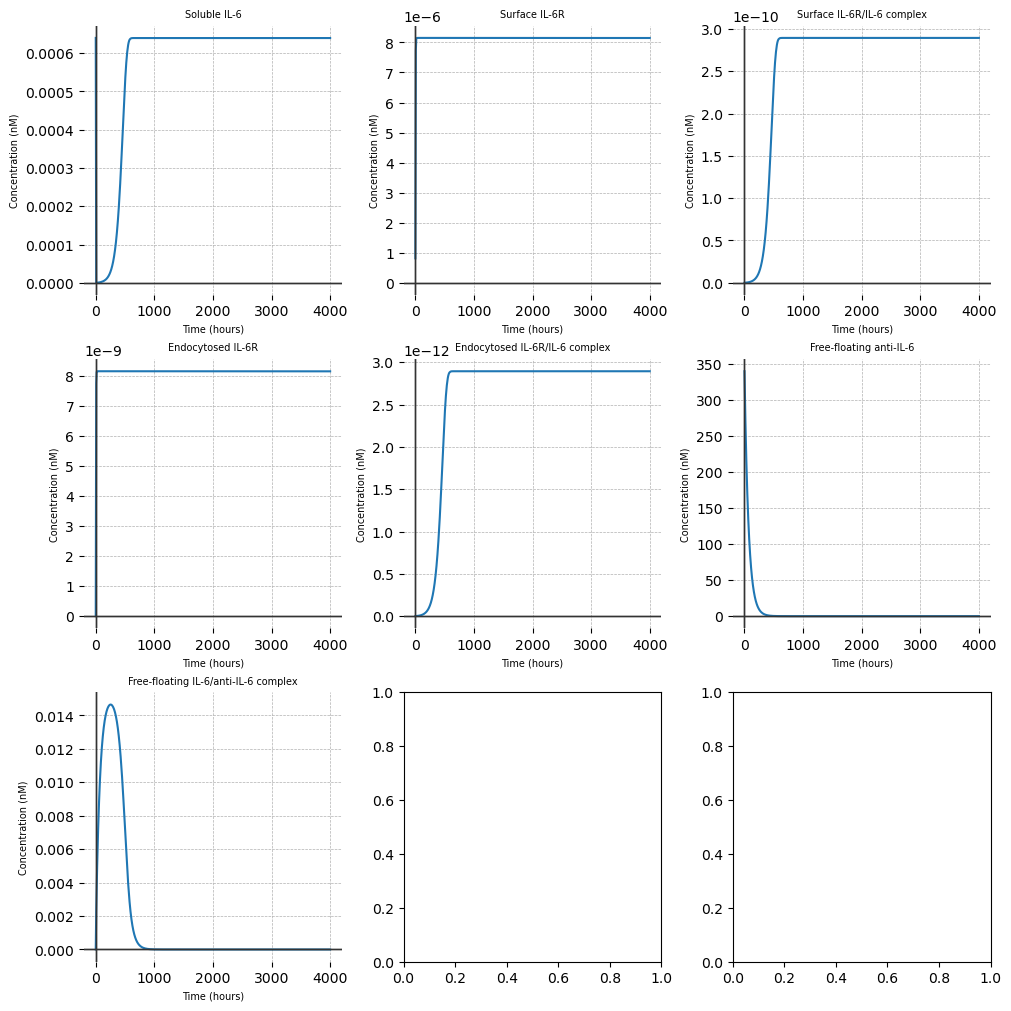

In [181]:
SAVE_FIGS = False   # CHANGE TO FALSE IF YOU WANT TO DISPLAY PLOTS AND NOT DOWNLOAD THEM

# create time axis
simulation_time_mins = 240000  # minutes
t = np.linspace(0, simulation_time_mins*60, 500)

for IL6 in IL6_initial:
        constants = rate_constants()
        metadata = state_variable_metadata(therapy='Ab')

        # Run the simulation
        simulation_results, solution = simulate_binding_recycling_and_degradation(t, constants, metadata)
        fig, axes = plt.subplots(3, 3, figsize=(10, 10), layout="constrained")
        axes = axes.flatten()
        # fig.suptitle(f'[L]0: {IL6} M\n\n',
        #                 fontsize=8)


        plot_time_axis = simulation_results['t']/3600

        for ax, (key, state_variable) in zip(axes,metadata.items()):
            ax.plot(plot_time_axis, simulation_results[key]*1e9)

            set_axes_labels(ax, 'Time (hours)', 'Concentration (nM)', state_variable.description, fontsize=7)
            make_plot_look_good(ax)

        if SAVE_FIGS:
            plt.savefig(f'all_ligand_{3}.png', dpi=300)
            plt.close(fig)
        else:
            plt.show()

        # make some overlay plots 
        # for key, state_variable in metadata.items():
        #     if 's' in key:   # surface species
        #         plt.plot(plot_time_axis, simulation_results[key]*1e9, label=metadata[key].description)

        # plt.xlabel('Time (mins)')
        # plt.ylabel('Concentration (nM)')
        # plt.legend()
        # plt.title(f'Surface species\n[L]0: {IL6} M')
        # if SAVE_FIGS:
        #     plt.savefig(f'surface_ligand_{IL6}.png', dpi=300)
        #     plt.close()
        # else:
        #     plt.show()

In [126]:
macrophage_conc * 1e9 * 1e5

1.6299999999999999e-06

In [ ]:
simulation_results['IL-6']